## Some Initialization steps

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

## Load Datasets

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Training Model on Epoch

In [3]:
def run_model(session, predict, Xd, yd,
              epochs=10, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    argmax = tf.cast(tf.argmax(predict,1), tf.int32)
    correct_prediction = tf.equal(argmax, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    best_ret = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now}#,keep_prob: 0.5
                         
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
            
        print('best accuracy:', best_ret)
    return total_loss,total_correct


## Summarization helper

In [4]:
tf.reset_default_graph()
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def conv2d_flatten(input_tensor):
    tensor_shape = input_tensor.get_shape()
    feature_channel = tensor_shape[1:4].num_elements()
    return tf.reshape(input_tensor, [-1, feature_channel]), feature_channel

## Building Nets and initializing Tensorflow variables

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, mean=0.0, stddev=1.0)
    #tf.get_variable("WC1", shape=[7, 7, 3, 32])
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def wrap_conv2d(input_tensor, wc, bc, strides=[1,2,2,1], padding='VALID'):#, data_format='NHWC' , data_format=data_format
    return tf.nn.conv2d(input_tensor, wc, strides=strides, padding=padding) + bc

def wrap_pool(input_tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'):
    h_pool = tf.nn.max_pool(input_tensor, ksize=ksize, strides=strides, padding=padding, name='Pooling')
    #print ("h_pool.shape",h_pool.shape)
    return h_pool

def cnn_init(input_tensor, input_dim, output_dim, tag_name, is_dropout=True, act=tf.nn.relu, pool=tf.nn.max_pool):
    # Add logical name score for parameters in this tag_named layer
    with tf.name_scope(tag_name):
        print('input_tensor.shape', input_tensor.shape)
        # Initial weight and name scope
        with tf.name_scope('Weight'):
            wc = weight_variable(input_dim)
            print ("wc.shape",wc.shape)
            variable_summaries(wc)
            
        # Initial bias and name scope
        with tf.name_scope('Bias'):
            bc = bias_variable([output_dim])
            variable_summaries(bc)
            
        
        # Convolution of inputs 
        with tf.name_scope('Conv2d'):
            conv = wrap_conv2d(input_tensor, wc, bc, padding='VALID')
            print ("conv.shape",conv.shape)
            variable_summaries(conv)
            
         
        # Activation of convolution layer
        with tf.name_scope('Activation'):
            activations = act(conv)#, name='activation'
            print ("activations.shape",activations.shape)
            variable_summaries(activations)
            
        tf.summary.histogram('activations', activations)
        
        # Pooling of the activations
        with tf.name_scope('Pooling'):
            pools = wrap_pool(activations, padding='VALID')
            print ("pools.shape",pools.shape)
            variable_summaries(pools)
        
        if is_dropout:
            # Regulgration with dropout
            with tf.name_scope('Dropout'):
                dropped = tf.nn.dropout(pools, keep_prob)
                print ("dropped.shape",dropped.shape)
                variable_summaries(dropped)
                return dropped
        else:
            return pools;
    
    
def dense_init(input_tensor, input_dim, output_dim, tag_name, act=tf.nn.relu):
    
    # Initial dense connection layer
    with tf.name_scope(tag_name):
        with tf.name_scope('Weight'):
            weight = weight_variable([input_dim, output_dim])
            print('weight', weight.shape)
            variable_summaries(weight)
            
        with tf.name_scope('Bias'):
            bias = bias_variable([output_dim])
            variable_summaries(bias)
            
        with tf.name_scope('Affine'):
            affined = tf.matmul(input_tensor, weight) + bias
            variable_summaries(affined)
            
        with tf.name_scope('Activation'):
            activation = act(affined)
            variable_summaries(activation)
            
        return activation
    


## Kick-off Graph Building Process

In [ ]:
def graph_init(input_tensor):
    conv1 = cnn_init(input_tensor, [7, 7, 3, 32], 32, 'Conv1', False)

    conv2 = cnn_init(conv1, [3, 3, 32, 64], 64, 'Conv2', False)

    #conv3 = cnn_init(conv2, [3, 3, 64, 32], 32, 'Conv3', False)

    flatten_layer, channels = conv2d_flatten(conv2)
    print('flatten_layer.shape',flatten_layer.shape)

    # Densely connection affien layer
    affin1 = dense_init(flatten_layer, channels, 256, 'affine1')
    print('affin1.shape',affin1.shape)

    predicts = dense_init(affin1, 256, 10, 'affine2')
    print('predicts.shape',predicts.shape)
    print('predicts type', type(predicts))
    return predicts
    
# Calculate cross entropy    
def calc_softmax(predicts):
    with tf.name_scope('softmax'):
        onehot_labels = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
        #diff = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=predicts)
        diff = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=predicts)

        with tf.name_scope('loss'):
            mean_loss =  tf.reduce_mean(diff)
        tf.summary.scalar('mean_loss', mean_loss)
    
    return mean_loss


## Training Model Preparing
The training data will be feed in run_model function, X, y, is_training, keep_prob should be also initialized here.

In [ ]:

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
is_training = tf.placeholder(tf.bool)  
keep_prob = tf.placeholder(tf.float32)

y_out = graph_init(X)
mean_loss = calc_softmax(y_out)   

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(mean_loss)



## Now Kick-off Run Session

In [ ]:
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,X_val,y_val,1,64)

In [ ]:
total_corrects = []

## Notice: You should probably run the rest of code from here. 

(?, 32, 32, 3)
h_conv1.shape (?, 13, 13, 32)
h1_relu.shape (?, 13, 13, 32)
h_pool1.shape (?, 6, 6, 32)
h_pool1_flat.shape (?, 1152)
h_fc1.shape (?, 1024)
Training
Iteration 0: with minibatch training loss = 2.63 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.54 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.59 and accuracy of 0.48
Iteration 300: with minibatch training loss = 1.57 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.48 and accuracy of 0.45
Iteration 500: with minibatch training loss = 1.37 and accuracy of 0.55
Iteration 600: with minibatch training loss = 1.32 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.54 and accuracy of 0.59
Epoch 1, Overall loss = 1.47 and accuracy of 0.483


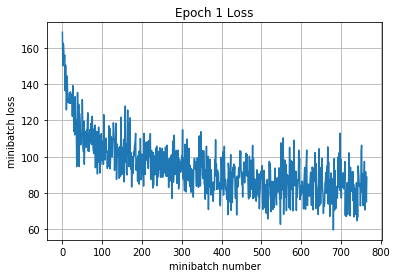

best accuracy: 0
Iteration 800: with minibatch training loss = 1.23 and accuracy of 0.58
Iteration 900: with minibatch training loss = 1.11 and accuracy of 0.66
Iteration 1000: with minibatch training loss = 1.22 and accuracy of 0.59
Iteration 1100: with minibatch training loss = 1.18 and accuracy of 0.64
Iteration 1200: with minibatch training loss = 1.04 and accuracy of 0.62
Iteration 1300: with minibatch training loss = 1.16 and accuracy of 0.61
Iteration 1400: with minibatch training loss = 1.21 and accuracy of 0.58
Iteration 1500: with minibatch training loss = 1.09 and accuracy of 0.69
Epoch 2, Overall loss = 1.13 and accuracy of 0.61


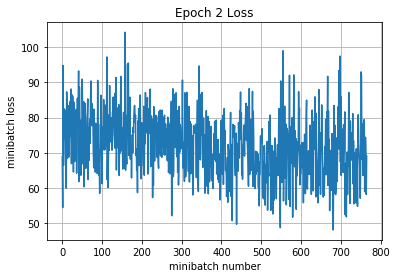

best accuracy: 0
Iteration 1600: with minibatch training loss = 1 and accuracy of 0.59
Iteration 1700: with minibatch training loss = 0.894 and accuracy of 0.7
Iteration 1800: with minibatch training loss = 0.88 and accuracy of 0.69
Iteration 1900: with minibatch training loss = 1.04 and accuracy of 0.61
Iteration 2000: with minibatch training loss = 0.819 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 1.03 and accuracy of 0.62
Iteration 2200: with minibatch training loss = 0.839 and accuracy of 0.73
Epoch 3, Overall loss = 0.975 and accuracy of 0.67


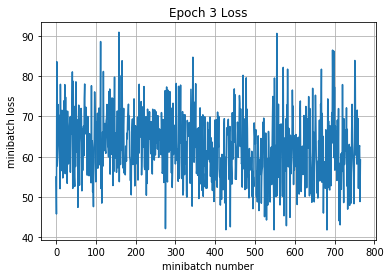

best accuracy: 0
Iteration 2300: with minibatch training loss = 1.19 and accuracy of 0.62
Iteration 2400: with minibatch training loss = 0.918 and accuracy of 0.75
Iteration 2500: with minibatch training loss = 0.933 and accuracy of 0.69
Iteration 2600: with minibatch training loss = 1.06 and accuracy of 0.66
Iteration 2700: with minibatch training loss = 0.836 and accuracy of 0.66
Iteration 2800: with minibatch training loss = 0.931 and accuracy of 0.73
Iteration 2900: with minibatch training loss = 0.859 and accuracy of 0.69
Iteration 3000: with minibatch training loss = 0.951 and accuracy of 0.72
Epoch 4, Overall loss = 0.867 and accuracy of 0.711


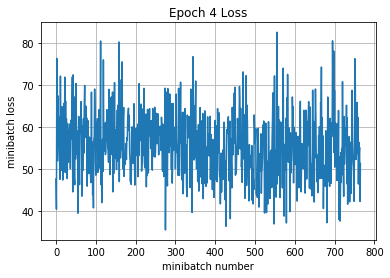

best accuracy: 0
Iteration 3100: with minibatch training loss = 0.705 and accuracy of 0.77
Iteration 3200: with minibatch training loss = 0.68 and accuracy of 0.7
Iteration 3300: with minibatch training loss = 0.828 and accuracy of 0.69
Iteration 3400: with minibatch training loss = 0.78 and accuracy of 0.75
Iteration 3500: with minibatch training loss = 0.854 and accuracy of 0.73
Iteration 3600: with minibatch training loss = 0.744 and accuracy of 0.77
Iteration 3700: with minibatch training loss = 0.814 and accuracy of 0.73
Iteration 3800: with minibatch training loss = 0.592 and accuracy of 0.8
Epoch 5, Overall loss = 0.778 and accuracy of 0.746


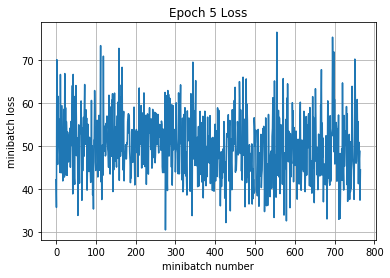

best accuracy: 0
Iteration 3900: with minibatch training loss = 0.668 and accuracy of 0.73
Iteration 4000: with minibatch training loss = 0.823 and accuracy of 0.77
Iteration 4100: with minibatch training loss = 0.63 and accuracy of 0.83
Iteration 4200: with minibatch training loss = 0.528 and accuracy of 0.83
Iteration 4300: with minibatch training loss = 0.926 and accuracy of 0.72
Iteration 4400: with minibatch training loss = 0.655 and accuracy of 0.83
Iteration 4500: with minibatch training loss = 0.673 and accuracy of 0.8
Epoch 6, Overall loss = 0.701 and accuracy of 0.777


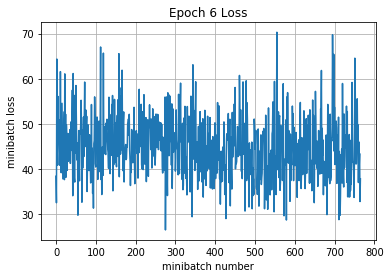

best accuracy: 0
Iteration 4600: with minibatch training loss = 0.57 and accuracy of 0.88
Iteration 4700: with minibatch training loss = 0.699 and accuracy of 0.8
Iteration 4800: with minibatch training loss = 0.611 and accuracy of 0.8
Iteration 4900: with minibatch training loss = 0.65 and accuracy of 0.81
Iteration 5000: with minibatch training loss = 0.65 and accuracy of 0.81
Iteration 5100: with minibatch training loss = 0.503 and accuracy of 0.89
Iteration 5200: with minibatch training loss = 0.596 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 0.723 and accuracy of 0.78
Epoch 7, Overall loss = 0.63 and accuracy of 0.807


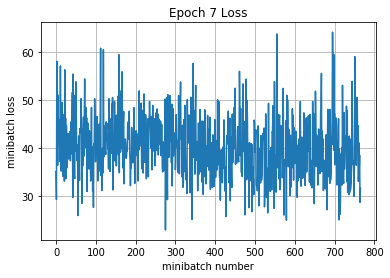

best accuracy: 0
Iteration 5400: with minibatch training loss = 0.633 and accuracy of 0.83
Iteration 5500: with minibatch training loss = 0.617 and accuracy of 0.83
Iteration 5600: with minibatch training loss = 0.563 and accuracy of 0.86
Iteration 5700: with minibatch training loss = 0.57 and accuracy of 0.83
Iteration 5800: with minibatch training loss = 0.416 and accuracy of 0.83
Iteration 5900: with minibatch training loss = 0.437 and accuracy of 0.89
Iteration 6000: with minibatch training loss = 0.652 and accuracy of 0.81
Iteration 6100: with minibatch training loss = 0.433 and accuracy of 0.92
Epoch 8, Overall loss = 0.564 and accuracy of 0.836


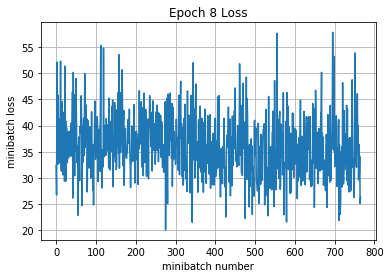

best accuracy: 0
Iteration 6200: with minibatch training loss = 0.714 and accuracy of 0.77
Iteration 6300: with minibatch training loss = 0.48 and accuracy of 0.84
Iteration 6400: with minibatch training loss = 0.482 and accuracy of 0.84
Iteration 6500: with minibatch training loss = 0.484 and accuracy of 0.88
Iteration 6600: with minibatch training loss = 0.55 and accuracy of 0.88
Iteration 6700: with minibatch training loss = 0.407 and accuracy of 0.91
Iteration 6800: with minibatch training loss = 0.398 and accuracy of 0.89
Epoch 9, Overall loss = 0.502 and accuracy of 0.863


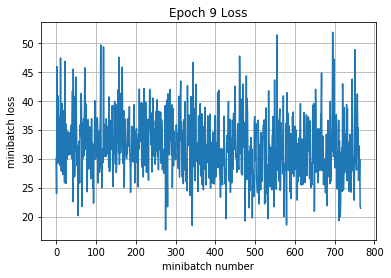

best accuracy: 0
Iteration 6900: with minibatch training loss = 0.476 and accuracy of 0.84
Iteration 7000: with minibatch training loss = 0.482 and accuracy of 0.89
Iteration 7100: with minibatch training loss = 0.343 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.434 and accuracy of 0.86
Iteration 7300: with minibatch training loss = 0.585 and accuracy of 0.89
Iteration 7400: with minibatch training loss = 0.33 and accuracy of 0.91
Iteration 7500: with minibatch training loss = 0.305 and accuracy of 0.94
Iteration 7600: with minibatch training loss = 0.337 and accuracy of 0.91
Epoch 10, Overall loss = 0.443 and accuracy of 0.887


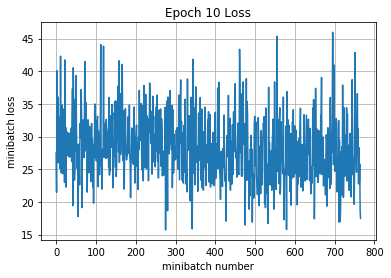

best accuracy: 0
Duration: 0:02:09.650577
Validation
Epoch 1, Overall loss = 1.05 and accuracy of 0.645
best accuracy: 0


In [5]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
is_training = tf.placeholder(tf.bool)  

def max_pool_2x2(input_tensor):
  return tf.nn.max_pool(input_tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


def batch_normalization(input_tensor, output_dim, is_training, tag_name):
    #with tf.name_scope(tag_name):
    with tf.name_scope('beta'):
        beta = tf.Variable(tf.constant(0.0, shape=[output_dim]))
        variable_summaries(beta)

    with tf.name_scope('gamma'):
        gamma = tf.Variable(tf.constant(1.0, shape=[output_dim]))
        variable_summaries(gamma)

    with tf.name_scope('normalization'):
        batch_mean, batch_var = tf.nn.moments(input_tensor, [0])

        ema = tf.train.ExponentialMovingAverage(decay=0.5)

    def batch_decay():
        ema_ops = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_ops]):
            return tf.identity(batch_mean), tf.identity(batch_var)

    mean, var = tf.cond(is_training,
                        batch_decay,
                        lambda: (ema.average(batch_mean), ema.average(batch_var)))

    return tf.nn.batch_normalization(input_tensor, mean, var, beta, gamma, 1e-3)
    
    
# define model
def inference_model(X,is_training):
    
    print(X.shape)
    #7x7 Convolutional Layer with 32 filters and stride of 1
    with tf.name_scope('conv1'):
        with tf.name_scope('weight'):
            WC1 = tf.get_variable("weight_conv", shape=[7, 7, 3, 32])
            variable_summaries(WC1)
            
        with tf.name_scope('bias'):        
            bc1 = tf.get_variable("bias_conv", shape=[32])
            variable_summaries(bc1)

        # Convoluton layer
        with tf.name_scope('conv2d'):
            h_conv1 = tf.nn.conv2d(X, WC1, strides=[1,2,2,1], padding='VALID') + bc1
            print ("h_conv1.shape",h_conv1.shape)

        # Batch normalization layer
        #with tf.name_scope('batch_norm'):
        #    batched = batch_normalization(h_conv1, 32, is_training, 'batch_norm')
            
        # ReLU activation nayer
        with tf.name_scope('ReLU'):
            #h1_relu = tf.nn.relu(h_conv1)
            h1_relu = tf.nn.relu(h_conv1)
            print ("h1_relu.shape",h1_relu.shape)

        # 2x2 Max Pooling layer with a stride of 2
        with tf.name_scope('pooling'):
            h_pool1 = max_pool_2x2(h1_relu)
            print ("h_pool1.shape",h_pool1.shape)

        with tf.name_scope('flatten'):
            h_pool1_flat, channels = conv2d_flatten(h_pool1)
            print ("h_pool1_flat.shape",h_pool1_flat.shape)
    
    with tf.name_scope('affine1'):
        
        #with tf.name_scope('batch_norm'):
        #    batched = tf.nn.batch_normalization(h_pool1, 0, 1, )
            
        # Affine layer with 1024 output units
        with tf.name_scope('weight'):
            WFC1 = tf.get_variable("dense_wight1", shape=[channels, 1024])
            variable_summaries(WFC1)
            
        with tf.name_scope('bias'):    
            bfc1 = tf.get_variable("dense_bias1", shape=[1024])
            variable_summaries(bfc1)
    
        with tf.name_scope('output'):
            output = tf.matmul(h_pool1_flat, WFC1) + bfc1
            
        with tf.name_scope('batch_norm'):
            batched = batch_normalization(output, 1024, is_training, 'batch_norm')
            
        # ReLU Activation Layer
        with tf.name_scope('ReLU'):
            h_fc1 = tf.nn.relu(batched)
            variable_summaries(h_fc1)
            print ("h_fc1.shape",h_fc1.shape)
    
    with tf.name_scope('affine2'):
        # Affine layer from 1024 input units to 10 outputs
        with tf.name_scope('weight'):
            WFC2 = tf.get_variable("dense_wight2", shape=[1024, 10])
            variable_summaries(WFC2)
            
        with tf.name_scope('bias'):    
            bfc2 = tf.get_variable("dense_bias2", shape=[10])
            variable_summaries(bfc2)
    
        with tf.name_scope('output'):
            y_out = tf.matmul(h_fc1,WFC2) + bfc2
            tf.summary.histogram('activations', y_out)
    return y_out

y_out = inference_model(X, is_training)

# define our loss
with tf.name_scope('softmax'):
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
    tf.summary.scalar('cross_entropy', total_loss)

with tf.name_scope('loss'):
    mean_loss = tf.reduce_mean(total_loss)
    tf.summary.scalar('mean_loss', mean_loss)


# define our optimizer
with tf.name_scope('Opts'):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(extra_update_ops):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(mean_loss)
        
log_path_train = 'VisualBoard/train'
log_path_test = 'VisualBoard/test'


from datetime import datetime
start_time = datetime.now()

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_path_train, sess.graph)
    test_writer = tf.summary.FileWriter(log_path_test)
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,X_train,y_train,10,64,100,train_step,True)
        end_time = datetime.now()
        print('Duration: {}'.format(end_time - start_time))
        print('Validation')
        run_model(sess,y_out,X_val,y_val,1,64)

##Best Records:
without Dropout: with minibatch training loss = 0.335 and accuracy of 0.95
    
recrod with Dropout: with minibatch training loss = 1.54 and accuracy of 0.52 
    
with BT  with minibatch training loss = 0.286 and accuracy of 0.97 

In [ ]:
without Dropout: with minibatch training loss = 0.335 and accuracy of 0.95
    
recrod with Dropout: with minibatch training loss = 1.54 and accuracy of 0.52 
    
with BT with minibatch training loss = 0.286 and accuracy of 0.97 
GPU: Duration: 0:02:13.028308